# AI Lab Pratical4 : Edge Detection and Image Sementation

## Introduction

In this section, we will explore the fundamental concepts of edge detection by applying several techniques, including Gradient-based methods, the Laplacian operator, the Canny edge detector, and corner detection. For the practical component, you are provided with a blurred image file, `blur.tif`, located in the `blur_image` folder. The objective of this laboratory exercise is to enhance the given image so that it appears clearer and visually improved.

In [9]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

## Introduction

In this section, we will explore the fundamental concepts of edge detection by applying several techniques, including Gradient-based methods, the Laplacian operator, the Canny edge detector, and corner detection. For the practical component, you are provided with a blurred image file, `blur.tif`, located in the `blur_image` folder. The objective of this laboratory exercise is to enhance the given image so that it appears clearer and visually improved.

### 1. Edge detection using Gradient ($\nabla$)

**Method 1**: Gradient Magnitude

* The gradient of an image:
$$\nabla I= [\frac{\partial I}{\partial x} \frac{\partial I}{\partial y}]$$

* The gradient points in the direction of fastest intensity change:

![Screenshot 2025-11-20 at 3.47.22 in the afternoon.png](<attachment:Screenshot 2025-11-20 at 3.47.22 in the afternoon.png>)
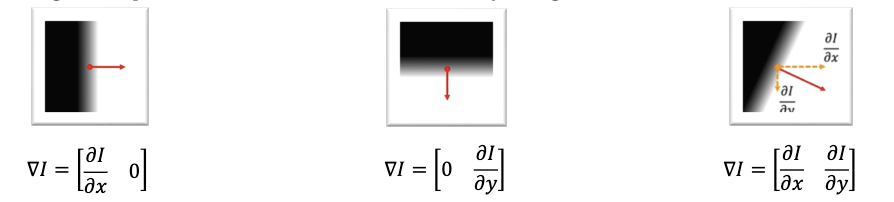

* The gradient direction (orientation of edge normal) is given by:
$$\theta = \tan^{-1}(\frac{\partial I}{\partial y}/\frac{\partial I}{\partial x})$$

* The edge strength is given by the gradient magnitude:
$$||\nabla I(x, y)||=\sqrt{(\frac{\partial I}{\partial x})^2 +(\frac{\partial I}{\partial y})^2}$$

In [10]:
# Load the image
img = cv2.imread('blur.tif', cv2.IMREAD_GRAYSCALE)
img_array = np.array(img, dtype=float)

In [11]:
# Compute gradients using Sobel operators (cv2)
gradient_x = cv2.Sobel(img_array, cv2.CV_64F, 1, 0, ksize=3)
gradient_y = cv2.Sobel(img_array, cv2.CV_64F, 0, 1, ksize=3)


In [12]:
# Compute gradient magnitude using cv2
gradient_magnitude = cv2.magnitude(gradient_x, gradient_y)

# Compute gradient direction (angle in degrees)
gradient_direction = cv2.phase(gradient_x, gradient_y, angleInDegrees=True)

# Normalize gradient magnitude to 0-255 range
gradient_magnitude_normalized = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

In [13]:
# Enhance the original image by adding gradient information
alpha = 0.5  # Weight for blending
enhanced_image = cv2.addWeighted(img_array.astype(np.uint8), 1.0, 
                                  gradient_magnitude_normalized, alpha, 0)
enhanced_image = np.clip(enhanced_image, 0, 255).astype(np.uint8)


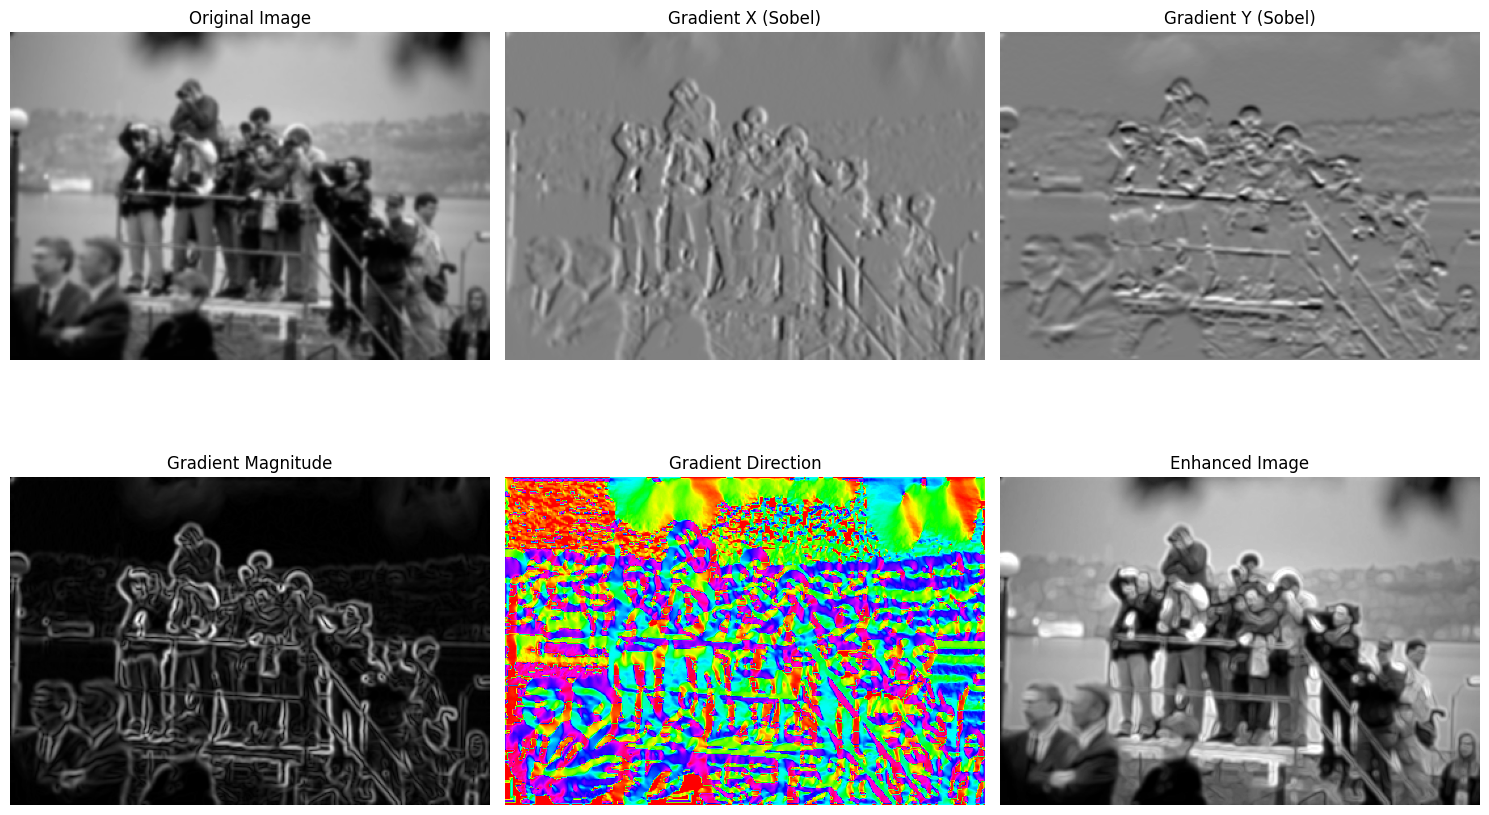

Original image shape: (250, 366)
Gradient magnitude range: [0.00, 466.47]
Enhanced image saved as 'enhanced_blur.tif'


In [14]:
# Display results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(img_array, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(gradient_x, cmap='gray')
axes[0, 1].set_title('Gradient X (Sobel)')
axes[0, 1].axis('off')

axes[0, 2].imshow(gradient_y, cmap='gray')
axes[0, 2].set_title('Gradient Y (Sobel)')
axes[0, 2].axis('off')

axes[1, 0].imshow(gradient_magnitude, cmap='gray')
axes[1, 0].set_title('Gradient Magnitude')
axes[1, 0].axis('off')

axes[1, 1].imshow(gradient_direction, cmap='hsv')
axes[1, 1].set_title('Gradient Direction')
axes[1, 1].axis('off')

axes[1, 2].imshow(enhanced_image, cmap='gray')
axes[1, 2].set_title('Enhanced Image')
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('gradient_enhancement_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Save the enhanced image
cv2.imwrite('enhanced_blur.tif', enhanced_image)
print(f"Original image shape: {img_array.shape}")
print(f"Gradient magnitude range: [{gradient_magnitude.min():.2f}, {gradient_magnitude.max():.2f}]")
print(f"Enhanced image saved as 'enhanced_blur.tif'")

**Method 2**: Edge Thresholding

* Standard (single threshold 𝑇)
    * $||\nabla I(x, y)||<T$: definitely not an edge
    * $||\nabla I(x, y)||\leq T$: definitely an edge

* Hysteresis bases (two thresholds $T_0\leq T_1$)
    * $||\nabla I(x, y)||<T_0$: definitely not an edge
    * $||\nabla I(x, y)||>T_1$: definitely an edge
    * $T_0\leq||\nabla I(x, y)||<T_1$: is an edge if a neighboring pixel is definitely an edge

In [15]:
# Method 2: Edge Thresholding

# 1. Standard (Single Threshold)
T = 50  # Threshold value (adjust based on gradient magnitude range)

# Apply single threshold
edges_single = np.zeros_like(gradient_magnitude, dtype=np.uint8)
edges_single[gradient_magnitude >= T] = 255

In [16]:
# 2. Hysteresis-based (Double Threshold)
T0 = 30  # Low threshold
T1 = 80  # High threshold

# Initialize edge map
edges_hysteresis = np.zeros_like(gradient_magnitude, dtype=np.uint8)

# Strong edges (definitely edges)
strong_edges = gradient_magnitude > T1
edges_hysteresis[strong_edges] = 255

# Weak edges (potential edges)
weak_edges = (gradient_magnitude >= T0) & (gradient_magnitude <= T1)

In [17]:
# Hysteresis: Connect weak edges to strong edges
# Use morphological dilation to find weak edges connected to strong edges
kernel = np.ones((3, 3), np.uint8)
strong_dilated = cv2.dilate(edges_hysteresis, kernel, iterations=1)

# Keep only weak edges connected to strong edges
edges_hysteresis[weak_edges & (strong_dilated == 255)] = 255

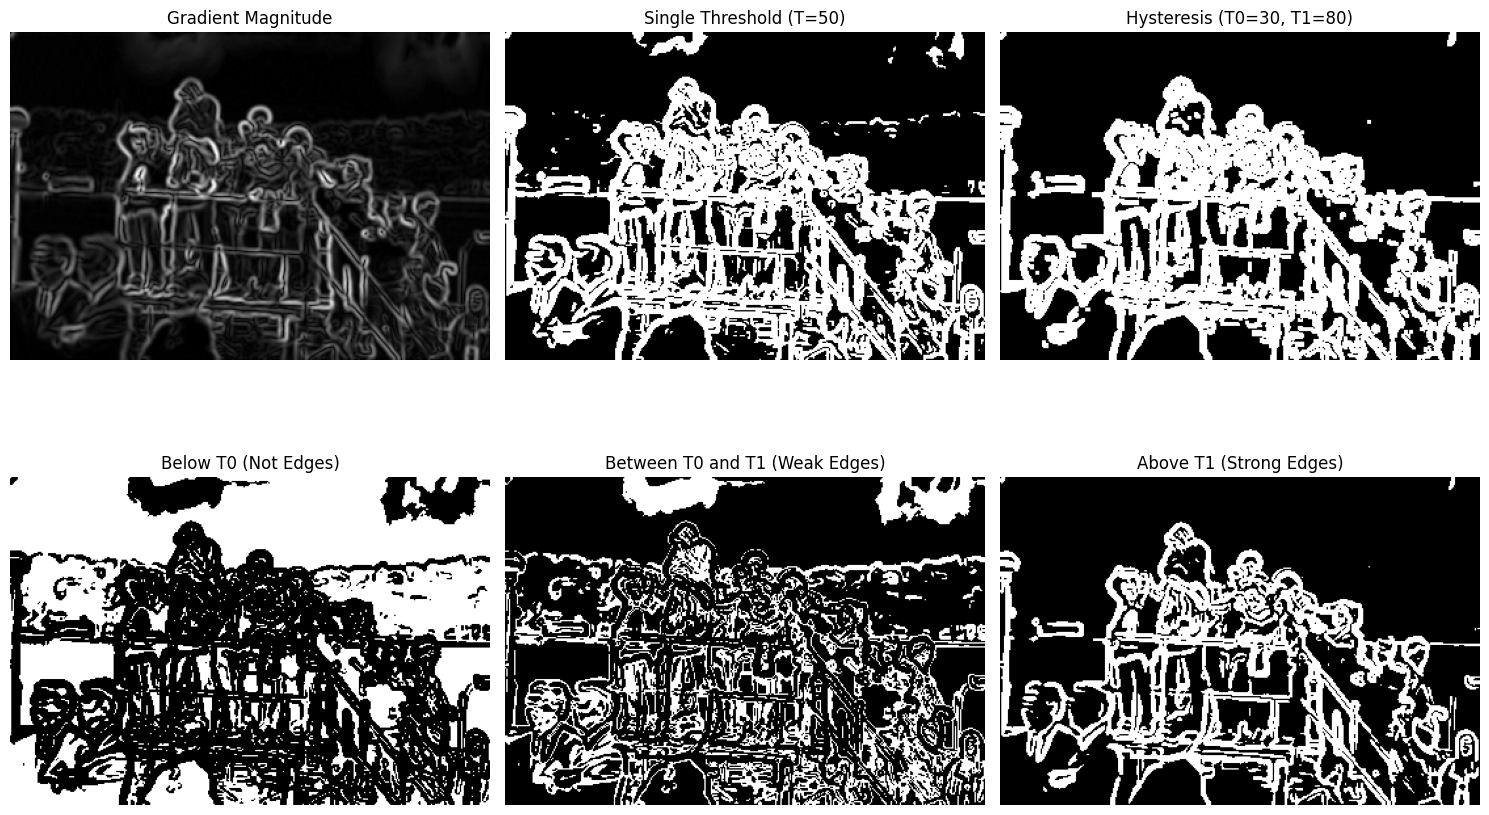

In [18]:
# Display thresholding results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(gradient_magnitude, cmap='gray')
axes[0, 0].set_title('Gradient Magnitude')
axes[0, 0].axis('off')

axes[0, 1].imshow(edges_single, cmap='gray')
axes[0, 1].set_title(f'Single Threshold (T={T})')
axes[0, 1].axis('off')

axes[0, 2].imshow(edges_hysteresis, cmap='gray')
axes[0, 2].set_title(f'Hysteresis (T0={T0}, T1={T1})')
axes[0, 2].axis('off')

# Show different threshold levels
axes[1, 0].imshow(gradient_magnitude < T0, cmap='gray')
axes[1, 0].set_title(f'Below T0 (Not Edges)')
axes[1, 0].axis('off')

axes[1, 1].imshow(weak_edges, cmap='gray')
axes[1, 1].set_title(f'Between T0 and T1 (Weak Edges)')
axes[1, 1].axis('off')

axes[1, 2].imshow(strong_edges, cmap='gray')
axes[1, 2].set_title(f'Above T1 (Strong Edges)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('edge_thresholding_results.png', dpi=150, bbox_inches='tight')
plt.show()

**Method 3**: Finite difference approximation

$$\frac{\partial I}{\partial x}\approx \frac{1}{2\epsilon}[(I_{i+1,j+1}-I_{i,j+1})-(I_{i+1,j}-I_{i,j})]$$

$$\frac{\partial I}{\partial y}\approx \frac{1}{2\epsilon}[(I_{i+1,j+1}-I_{i+1,j})-(I_{i,j+1}-I_{i,j})]$$

Some kernels gradient ($\nabla$) operators:

|Gradient|Roberts|Prewitt|Sobel(3x3)|Sobel(5x5)|
|--------|-------|-------|----------|----------|
|$\frac{\partial I}{\partial x}$|$\begin{bmatrix}0&1\\-1&0\end{bmatrix}$|$\begin{bmatrix}-1&0&1\\-1&0&1\\-1&0&1\end{bmatrix}$|$\begin{bmatrix}-1&0&1\\-2&0&2\\-1&0&1\end{bmatrix}$|$\begin{bmatrix}-1&-2&0&2&1\\-2&-3&0&3&2\\-3&-5&0&5&3\\-2&-3&0&3&2\\-1&-2&0&2&1\end{bmatrix}$|
|$\frac{\partial I}{\partial y}$|$\begin{bmatrix}1&0\\0&-1\end{bmatrix}$|$\begin{bmatrix}1&1&1\\0&0&0\\-1&-1&-1\end{bmatrix}$|$\begin{bmatrix}1&2&1\\0&0&0\\-1&-2&-1\end{bmatrix}$|$\begin{bmatrix}1&2&3&2&1\\2&3&5&3&2\\0&0&0&0&0\\-2&-3&-5&3&2\\-1&-2&-3&2&1\end{bmatrix}$|

### 3. Canny Edge Detector:
Experiment this technic for impove image quality of image given `blur.tif`.

In [19]:
# 1. Apply Canny edge detection
# Canny automatically uses gradient computation and hysteresis thresholding
threshold1 = 50   # Lower threshold for hysteresis
threshold2 = 150  # Upper threshold for hysteresis

edges_canny = cv2.Canny(img.astype(np.uint8), threshold1, threshold2)


In [26]:
# 2. Different approaches to enhance the original image using Canny edges

# Approach 1: Overlay edges on original image
enhanced_overlay = img.copy()
enhanced_overlay[edges_canny > 0] = 255

# Approach 2: Add weighted edges to original
edges_colored = cv2.cvtColor(edges_canny, cv2.COLOR_GRAY2BGR)
img_colored = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_GRAY2BGR)
enhanced_weighted = cv2.addWeighted(img_colored, 0.7, edges_colored, 0.3, 0)

# Approach 3: Sharpen using edge information
# Create sharpening kernel from edges
blur_kernel = cv2.GaussianBlur(img.astype(np.uint8), (5, 5), 1.0)
enhanced_sharpened = cv2.addWeighted(img.astype(np.uint8), 1.5, blur_kernel, -0.5, 0)
enhanced_sharpened[edges_canny > 0] = np.clip(enhanced_sharpened[edges_canny > 0] + 50, 0, 255)

# Approach 4: Advanced - Use edges to guide deblurring
# Apply bilateral filter to preserve edges while smoothing
enhanced_bilateral = cv2.bilateralFilter(img.astype(np.uint8), 9, 75, 75)
# Enhance edges detected by Canny
edge_mask = edges_canny > 0
enhanced_bilateral[edge_mask] = img.astype(np.uint8)[edge_mask]

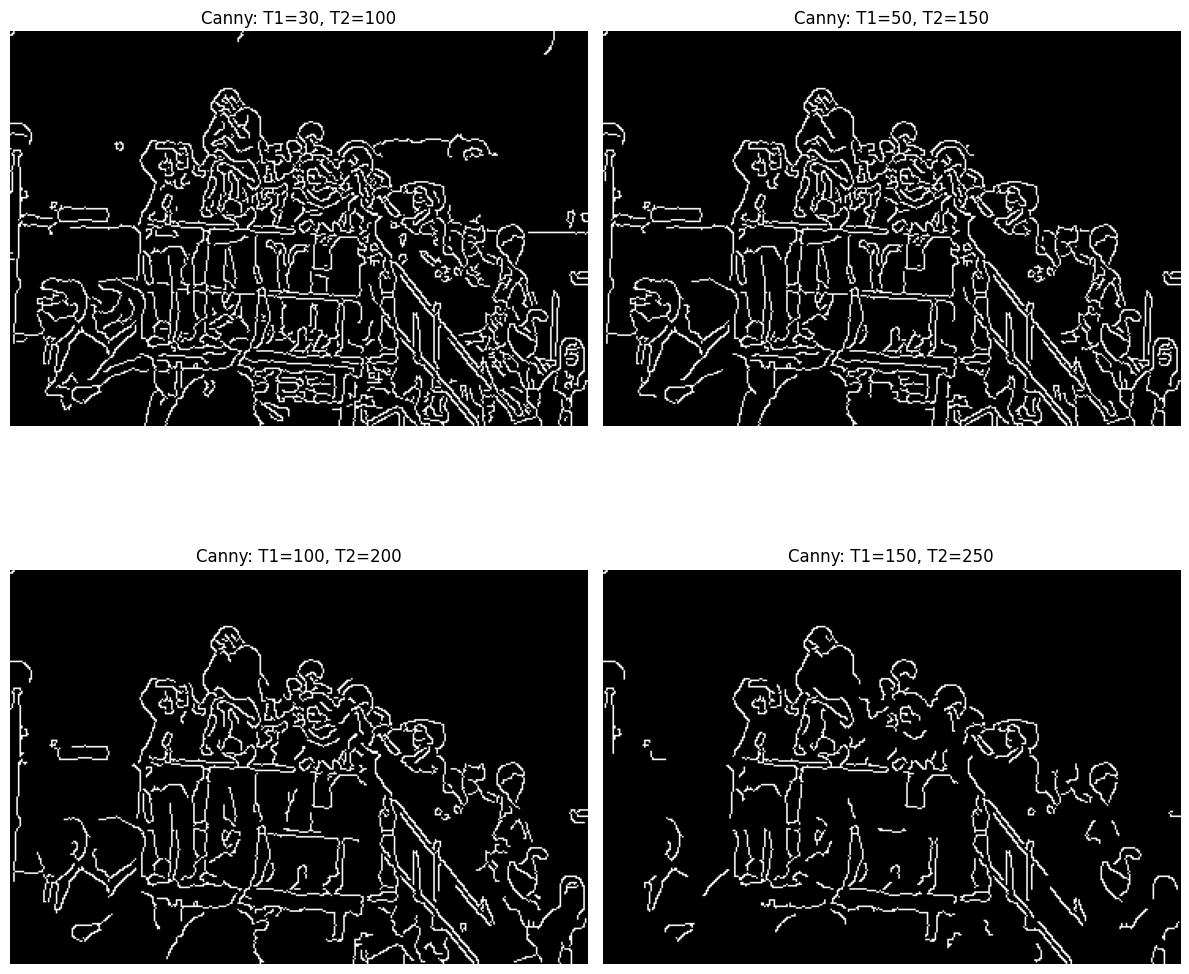

In [27]:
# 3. Try different Canny parameters
canny_results = []
params = [(30, 100), (50, 150), (100, 200), (150, 250)]

for t1, t2 in params:
    edges = cv2.Canny(img.astype(np.uint8), t1, t2)
    canny_results.append((edges, f'T1={t1}, T2={t2}'))

# Display all Canny results with different parameters
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for idx, (edges, label) in enumerate(canny_results):
    row, col = idx // 2, idx % 2
    axes[row, col].imshow(edges, cmap='gray')
    axes[row, col].set_title(f'Canny: {label}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('canny_parameters_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

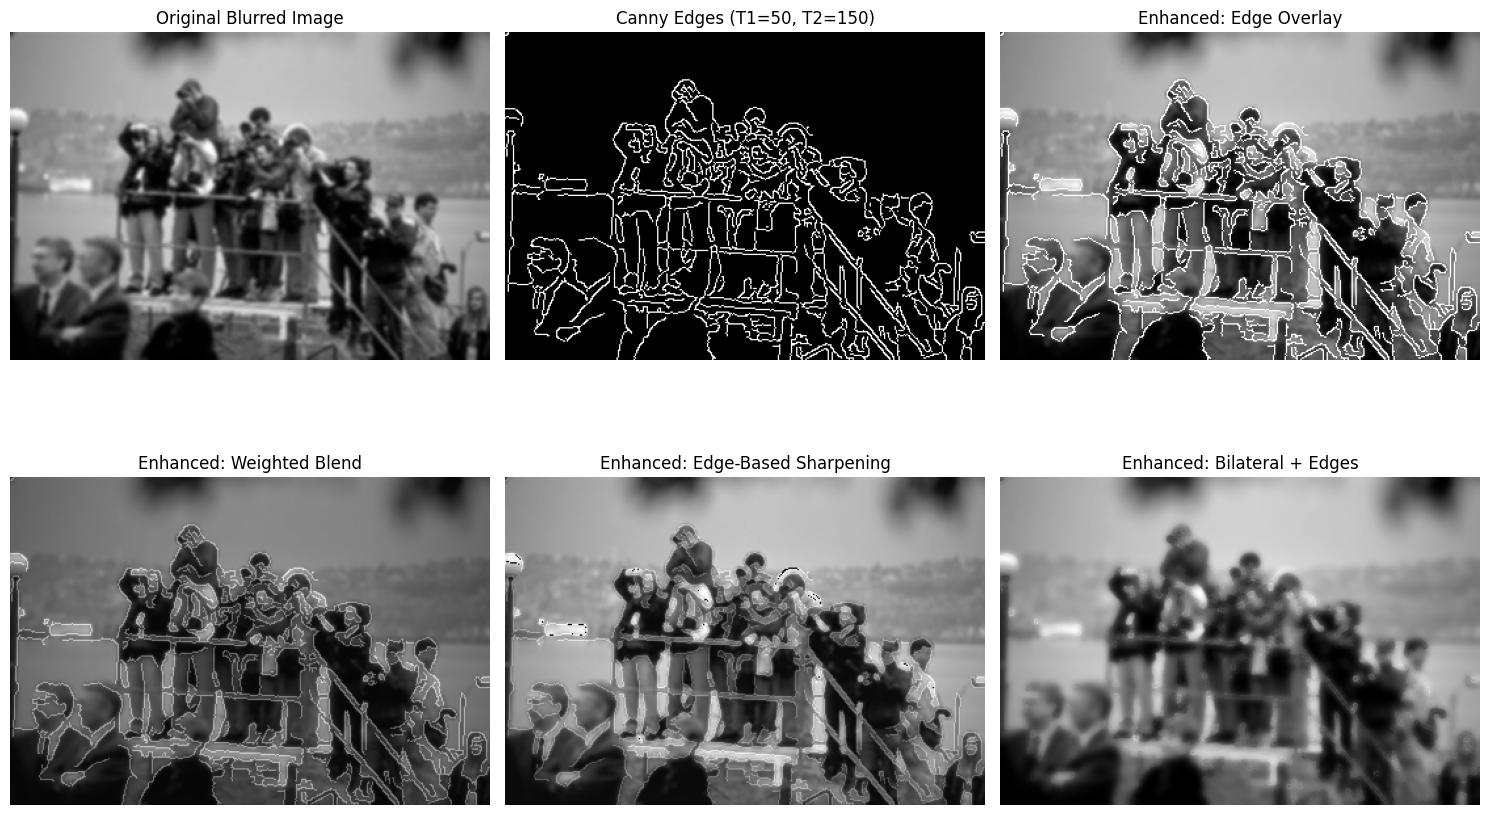

In [28]:
# Display enhancement results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(img, cmap='gray')
axes[0, 0].set_title('Original Blurred Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(edges_canny, cmap='gray')
axes[0, 1].set_title(f'Canny Edges (T1={threshold1}, T2={threshold2})')
axes[0, 1].axis('off')

axes[0, 2].imshow(enhanced_overlay, cmap='gray')
axes[0, 2].set_title('Enhanced: Edge Overlay')
axes[0, 2].axis('off')

axes[1, 0].imshow(enhanced_weighted)
axes[1, 0].set_title('Enhanced: Weighted Blend')
axes[1, 0].axis('off')

axes[1, 1].imshow(enhanced_sharpened, cmap='gray')
axes[1, 1].set_title('Enhanced: Edge-Based Sharpening')
axes[1, 1].axis('off')

axes[1, 2].imshow(enhanced_bilateral, cmap='gray')
axes[1, 2].set_title('Enhanced: Bilateral + Edges')
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('canny_enhancement_results.png', dpi=150, bbox_inches='tight')
plt.show()


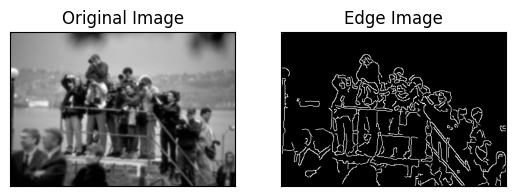

In [29]:
img = cv2.imread('blur.tif', cv2.IMREAD_GRAYSCALE)
# assert img is not None, "file could not be read, check with os.path.exists()"
edges = cv2.Canny(img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

### 4. Corner Edge Detector

Experiment this technic for impove image quality of image given `blur.tif`.

In [30]:
# Load the image
img = cv2.imread('blur.tif', cv2.IMREAD_GRAYSCALE)

# 1. Harris Corner Detection
harris_corners = cv2.cornerHarris(img.astype(np.float32), blockSize=2, ksize=3, k=0.04)

# Dilate to mark corners
harris_dilated = cv2.dilate(harris_corners, None)

# Threshold for optimal corner detection (adjust threshold as needed)
threshold = 0.01 * harris_corners.max()
corner_mask_harris = harris_corners > threshold

# Create enhanced image with Harris corners
enhanced_harris = img.copy()
enhanced_harris[corner_mask_harris] = 255

In [34]:
# 2. Shi-Tomasi Corner Detection (Good Features to Track)
corners_shi_tomasi = cv2.goodFeaturesToTrack(
    img, 
    maxCorners=200,      # Maximum number of corners
    qualityLevel=0.01,   # Quality threshold
    minDistance=10,      # Minimum distance between corners
    blockSize=3
)

# Create enhanced image with Shi-Tomasi corners
enhanced_shi_tomasi = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
if corners_shi_tomasi is not None:
    corners_shi_tomasi = np.intp(corners_shi_tomasi)
    for corner in corners_shi_tomasi:
        x, y = corner.ravel()
        cv2.circle(enhanced_shi_tomasi, (x, y), 3, (0, 255, 0), -1)

In [35]:
# 3. FAST (Features from Accelerated Segment Test) Corner Detection
fast = cv2.FastFeatureDetector_create(threshold=25, nonmaxSuppression=True)
keypoints_fast = fast.detect(img, None)

# Draw FAST corners
enhanced_fast = cv2.drawKeypoints(img, keypoints_fast, None, color=(255, 0, 0))

In [36]:
# 4. Combined Enhancement using corners
# Combine Harris corners with image sharpening
enhanced_combined = img.copy()

# Apply unsharp masking
gaussian_blur = cv2.GaussianBlur(img, (5, 5), 1.0)
enhanced_combined = cv2.addWeighted(img, 1.5, gaussian_blur, -0.5, 0)

# Enhance detected corners
enhanced_combined[corner_mask_harris] = 255


In [37]:
# 5. Advanced: Use corners to guide bilateral filtering
enhanced_bilateral_corners = cv2.bilateralFilter(img, 9, 75, 75)
# Preserve corner information
enhanced_bilateral_corners[corner_mask_harris] = img[corner_mask_harris]


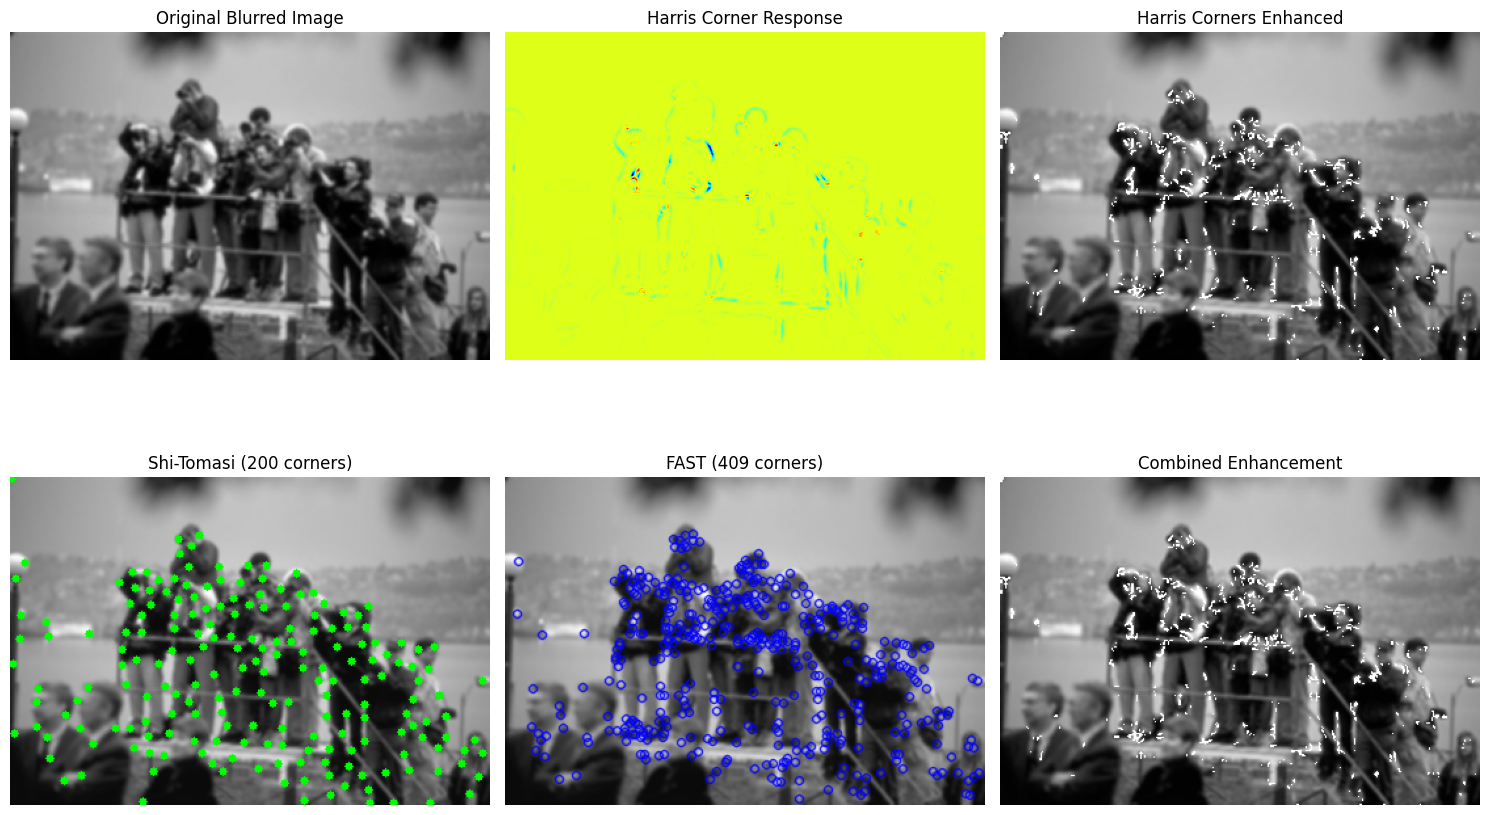

In [38]:
# 6. Compare different corner detectors
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(img, cmap='gray')
axes[0, 0].set_title('Original Blurred Image')
axes[0, 0].axis('off')

# Visualize Harris corner response
axes[0, 1].imshow(harris_corners, cmap='jet')
axes[0, 1].set_title('Harris Corner Response')
axes[0, 1].axis('off')

axes[0, 2].imshow(enhanced_harris, cmap='gray')
axes[0, 2].set_title('Harris Corners Enhanced')
axes[0, 2].axis('off')

axes[1, 0].imshow(cv2.cvtColor(enhanced_shi_tomasi, cv2.COLOR_BGR2RGB))
axes[1, 0].set_title(f'Shi-Tomasi ({len(corners_shi_tomasi) if corners_shi_tomasi is not None else 0} corners)')
axes[1, 0].axis('off')

axes[1, 1].imshow(cv2.cvtColor(enhanced_fast, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title(f'FAST ({len(keypoints_fast)} corners)')
axes[1, 1].axis('off')

axes[1, 2].imshow(enhanced_combined, cmap='gray')
axes[1, 2].set_title('Combined Enhancement')
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('corner_detection_results.png', dpi=150, bbox_inches='tight')
plt.show()


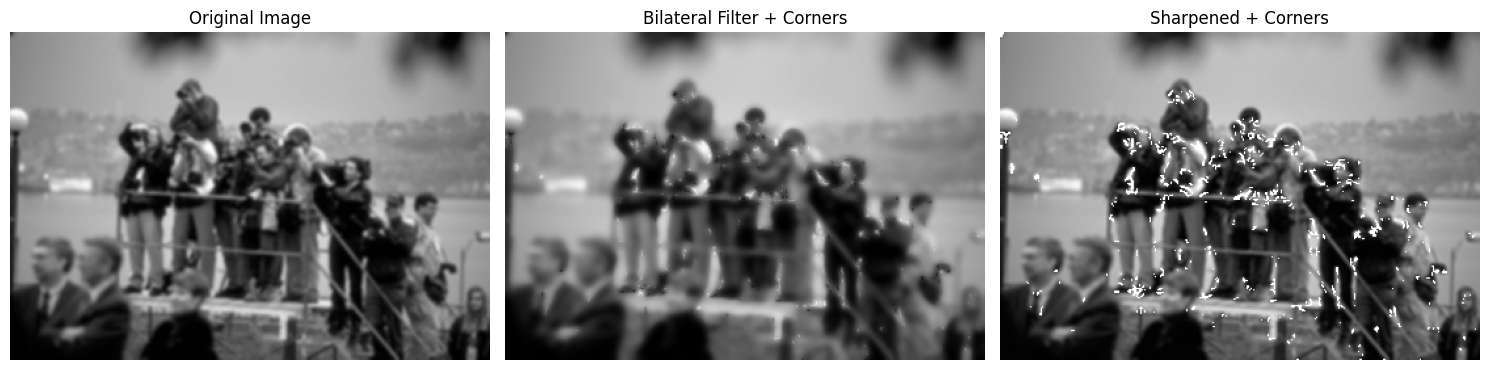

In [39]:
# 7. Display advanced enhancement techniques
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(enhanced_bilateral_corners, cmap='gray')
axes[1].set_title('Bilateral Filter + Corners')
axes[1].axis('off')

axes[2].imshow(enhanced_combined, cmap='gray')
axes[2].set_title('Sharpened + Corners')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('corner_enhancement_comparison.png', dpi=150, bbox_inches='tight')
plt.show()